In [1]:
import argparse
from time import time

import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
import torch
from torch.autograd import Variable
from torch.utils.data import DataLoader

from scipy.signal import savgol_filter
import time as time



In [2]:
from util import *

In [3]:
"""     LOADING DATASET       """
seed = 0
data = pd.read_csv('./data/adult.csv')
data

,age,workclass,fnlwgt,education,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K
4,18,?,103497,Some-college,10,Never-married,?,Own-child,White,Female,0,0,30,United-States,<=50K
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48837,27,Private,257302,Assoc-acdm,12,Married-civ-spouse,Tech-support,Wife,White,Female,0,0,38,United-States,<=50K
48838,40,Private,154374,HS-grad,9,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0,0,40,United-States,>50K
48839,58,Private,151910,HS-grad,9,Widowed,Adm-clerical,Unmarried,White,Female,0,0,40,United-States,<=50K
48840,22,Private,201490,HS-grad,9,Never-married,Adm-clerical,Own-child,White,Male,0,0,20,United-States,<=50K


In [4]:
"""3.2 UNDERSTANDING THE DATASET"""
"Income Counts is series object with counts for <=50K and >50K values"
incomeCounts = data['income'].value_counts()
numHighEarners = incomeCounts[">50K"] # 11 687
numLowEarners = incomeCounts['<=50K'] # 37 155

print("Number of High Income Earners: %d \n    Number of Low Income Earners: %d" % (numHighEarners,numLowEarners))


3.2.1) 
    Number of High Income Earners: 11687 
    Number of Low Income Earners: 37155


In [5]:
"""3.3 CLEANING DATASET"""

print('N/A Values in Cols: ')
initNumRows = data.shape[0]

for col in data:
    print('\t',col,data[col].isin(['?']).sum())
print('/n')


N/A Values in Cols: 
	 age 0
	 workclass 2799
	 fnlwgt 0
	 education 0
	 educational-num 0
	 marital-status 0
	 occupation 2809
	 relationship 0
	 race 0
	 gender 0
	 capital-gain 0
	 capital-loss 0
	 hours-per-week 0
	 native-country 857
	 income 0
/n


In [6]:
colWQ = ['workclass','occupation','native-country']
for col in colWQ:
    data = data[data[col] != '?']
finNumRows = data.shape[0]
print(' %d rows thrown out. ' % (initNumRows-finNumRows))
print(data.shape)

3.3.1) 
    3620 rows thrown out. 
(45222, 15)


In [7]:
# =================================== 3.4 BALANCE DATASET =========================================== #

lowEarnersDF = data[data['income'] == '<=50K']
highEarnersDF = data[data['income'] == '>50K']


lowEarnersDF = lowEarnersDF.sample(n=len(highEarnersDF),random_state=0)
data = pd.concat([lowEarnersDF,highEarnersDF],ignore_index=True)

    ######
print(data.shape)


(22416, 15)


In [8]:
"""3.5 VISUALIZATION AND UNDERSTANDING"""
(data.describe().head())


,age,fnlwgt,educational-num,capital-gain,capital-loss,hours-per-week
count,22416.000000,22416.000000,22416.000000,22416.000000,22416.000000,22416.000000
mean,40.329006,189366.055407,10.617684,2071.453828,123.980728,42.594040
std,12.590194,104837.760612,2.586669,10532.427796,478.371045,11.832265
min,17.000000,13492.000000,1.000000,0.000000,0.000000,1.000000
25%,31.000000,117695.750000,9.000000,0.000000,0.000000,40.000000


In [9]:
minHPW = (data.describe())['hours-per-week']['min']

print(' Min of Hours Per Week: %f' % (float(minHPW)))

3.5.1) 
    Min of Hours Per Week: 1.000000


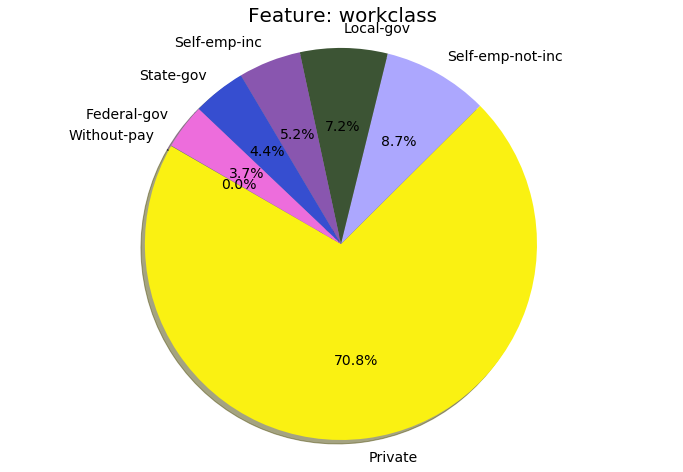

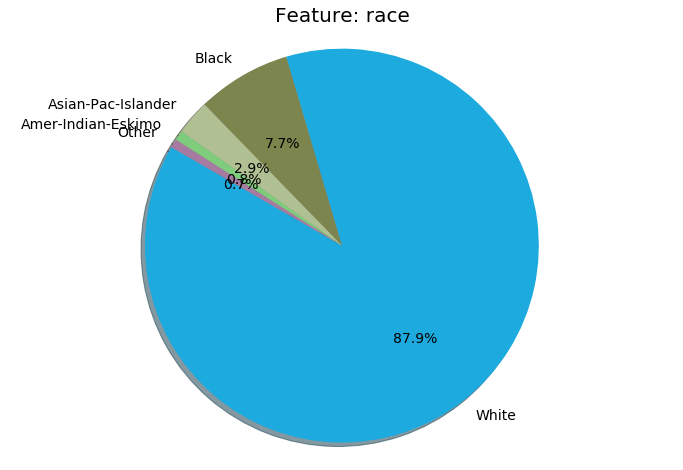

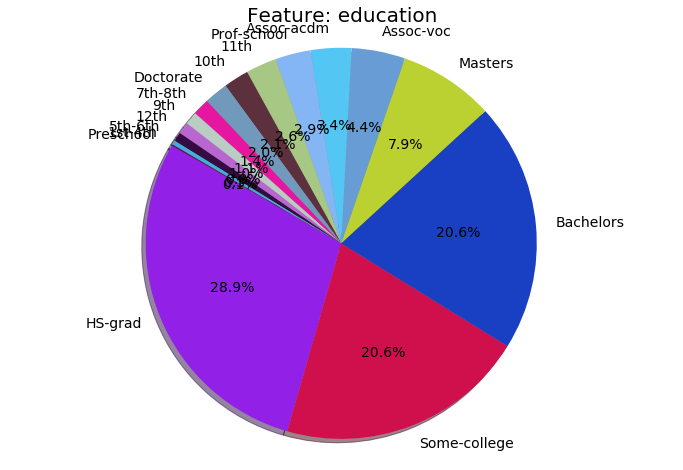

In [10]:
categorical_feats = ['workclass', 'race', 'education', 'marital-status', 'occupation',
                    'relationship', 'gender', 'native-country', 'income']
for cat in range(0,3,1):
    pie_chart(dataset=data,column=categorical_feats[cat])

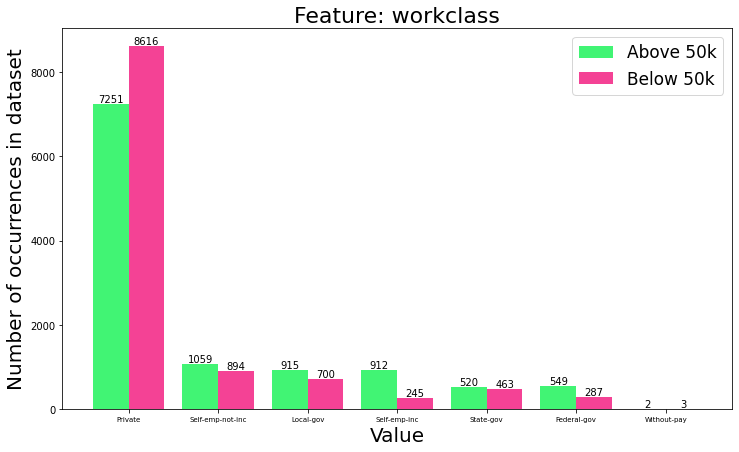

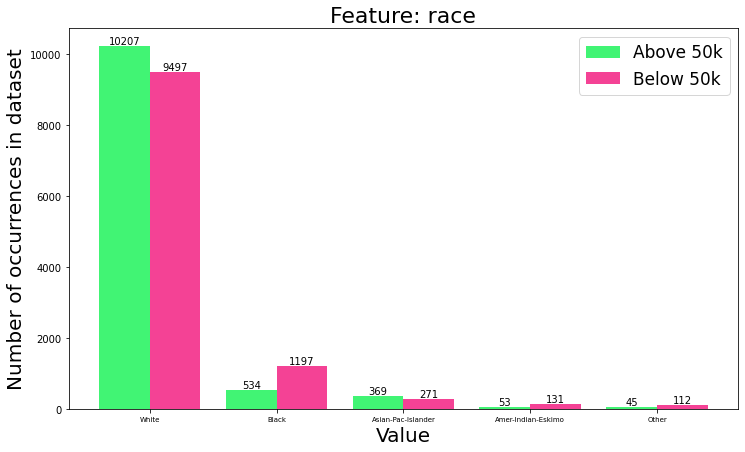

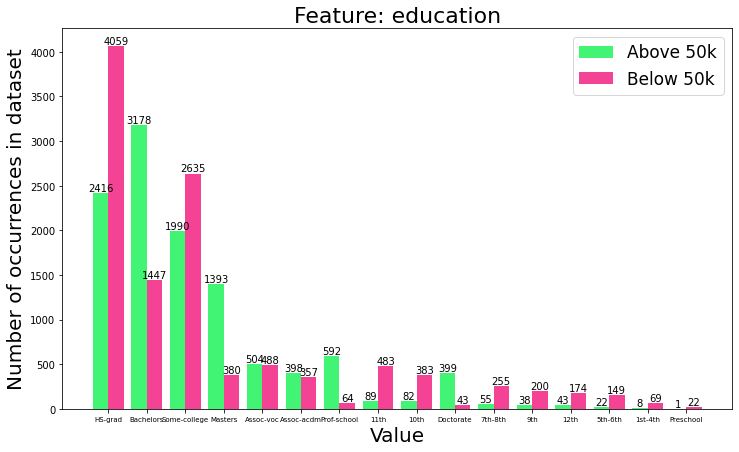

In [217]:
for cat in range(0,3,1):
    binary_bar_chart(dataset=data,column=categorical_feats[cat])


In [12]:
"""3.6 PREPROCESSING... run this cell twice"""


catLabeled = []
for col in categorical_feats:
    labelencoder = LabelEncoder()
    cLabel = labelencoder.fit_transform(data[col])
    catLabeled += [cLabel]
catLabeled = (np.array(catLabeled)).T
print(catLabeled.shape)

# sometimes income gets removed...
if 'income' in data.columns:  
    print('removing income...')
    y = data['income'].values
    data = data.drop(columns=['income'])
    categorical_feats.remove('income')

oneh_encoder = OneHotEncoder(sparse=False) # don't want sparse object, want and ndarray
cat_onehot = oneh_encoder.fit_transform(catLabeled)
print(cat_onehot.shape)
catDF = pd.DataFrame(cat_onehot) # need to stitch back later...

"""For cts data"""
cts_data = data.drop(columns=categorical_feats)
ctsNorm = []
for col in cts_data.columns:
    mu = (cts_data[col]).mean()
    std = (cts_data[col]).std()
    colNorm = (cts_data[col] - mu) / std
    ctsNorm += [colNorm]

# overwrite 
cts_data = (np.array(ctsNorm)).T
ctsDF = pd.DataFrame(cts_data)
print(ctsDF.shape)
print(catDF.shape)


print(catDF.shape)
print(ctsDF.shape)
"""Stitch back"""
X = pd.concat([ctsDF,catDF],axis=1)
X = X.values
X.shape
print("Shape of X =", X.shape)

(22416, 8)
(22416, 97)
(22416, 6)
(22416, 97)
(22416, 97)
(22416, 6)
Shape of X = (22416, 103)


In [13]:
"""3.7 Train-validation split"""
# inputs need to be arrays ^^^
xTrain,xTest,yTrain,yTest = train_test_split(X,y,test_size=0.2,random_state=0)

for i in range(len(yTrain)):
    if yTrain[i] == '>50K':
        yTrain[i] = 1
    else:
        yTrain[i] = 0
for i in range(len(yTest)):
    if yTest[i] == '>50K':
        yTest[i] = 1
    else:
        yTest[i] = 0



In [14]:
"""From dataset.py"""
# 
from torch.utils.data import Dataset

class AdultDataset(Dataset):
    
    def __init__(self,X,y,transform=None):
        self.samples = X
        self.labels = y

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, index):
        return torch.from_numpy(self.samples[index]),self.labels[index]

In [15]:
"""4.2 Dataset"""
def load_data(batch_size):
    trainDS = AdultDataset(xTrain,yTrain)
    validDS = AdultDataset(xTest,yTest)

    train_loader = DataLoader(trainDS,batch_size=batch_size,shuffle=True)
    val_loader = DataLoader(validDS,batch_size=batch_size)
    return train_loader, val_loader

In [16]:
from torch.optim import SGD
import torch.nn as nn
import matplotlib.pyplot as plt

In [17]:
"""4.3 Model"""

class MultiLayerPerceptron(nn.Module):

    def __init__(self, input_size):

        super(MultiLayerPerceptron, self).__init__()
        self.fc1 = nn.Linear(input_size,64)
        self.fc2 = nn.Linear(64,1)
        self.relu = nn.ReLU()
        self.tanh = nn.Tanh()
        self.sigmoid = nn.Sigmoid()

    def forward(self, features):
        out = self.fc1(features)
        out = self.tanh(out)
        out = self.fc2(out)
        out = self.tanh(out)
        out = self.sigmoid(out)
        return out

In [18]:
"""4.4 Loss Function and Optimizer"""

def load_model(lr,inSize):
    # lr is learning rate
    model = MultiLayerPerceptron(inSize)
    optimizer = SGD(model.parameters(),lr)
    loss_fnc = nn.MSELoss()
    return model, loss_fnc, optimizer

In [19]:
"""Helper functions"""

def accuracy(y_hat,label):   
    numSamp = len(label)
    correct = 0
    for i in range(0,numSamp,1):
        if (y_hat[i].item() > 0.5 and label[i].item() == 1) or (y_hat[i].item() <=0.5 and label[i].item() == 0):
            correct += 1
    acc = correct / numSamp

    return acc

def smoothAvg(x,evalEvery):
    # x is a numpy array 
    start = 0
    end = evalEvery
    rval = [x[j] for j in range(start,end,1)]
    for i in range(0,len(x),1):
        if i <= (evalEvery-1):
            continue
        else:
            if end > len(x):
                arr = x[start:]
            else:
                arr = x[start:end]
            start += 1
            end += 1
            rval += [float(arr.mean())]
    return rval


In [20]:
"""4.6 Validation"""
def evaluate(model, val_loader):  
    total_corr = 0 
    for idx, (inputs,labels) in enumerate(val_loader):
        yhat = model(inputs.float())

        for i in range(0,len(labels),1):
            if (yhat[i].item() > 0.5 and labels[i].item() == 1) or (yhat[i].item() <= 0.5 and labels[i].item() == 0):
                total_corr += 1
    return float(total_corr)/len(val_loader.dataset)


In [21]:
batchSize = 64
numEpochs = 5
lr = 0.1
evalEvery = 10

In [22]:
def main(batchSize,numEpochs,lr,evalEvery):


    trainLoader,validLoader = load_data(batch_size=batchSize)

    model, criterion, optimizer = load_model(lr=lr,inSize=103)

    trainAcc,trainLoss,validAcc = [],[],[]
    numBatches = 0
    # avg = 0

    start = 0; end = 0;
    tic = time.time()
    t = []
    for epoch in range(numEpochs):
        # print('At Epoch: ',epoch)

        for idx, (inputs,labels) in enumerate(trainLoader,0):
            # clear gradients
            optimizer.zero_grad()
            # get predictions
            outputs = model(inputs.float())
            # compute loss and step
            loss = criterion(outputs.squeeze(),labels.float())
            loss.backward()
            optimizer.step()

            
            
            if idx % (evalEvery) == 0:

                numBatches += 1

                trainLoss += [loss.item()]

                trainAccuracy = accuracy(outputs,labels.float())
                avg = trainAccuracy
                if len(trainAcc) < evalEvery:
                    avg = trainAccuracy
                elif len(trainAcc) >= evalEvery:
                    if end > len(trainAcc):
                        end = len(trainAcc)
                    for i in range(start,end,1):
                        avg += (trainAcc[i])/evalEvery
                start += 1; end += 1
                t += [time.time() - tic]
                trainAcc += [trainAccuracy]
                validAccuracy = evaluate(model,validLoader)
                validAcc += [validAccuracy]

                print('Epoch Num: ',epoch)
                print('Number of Correct Training Predictions: %d' % int(trainAccuracy*len(outputs)))
                print("Avg Train Accuracy (%d most recent batches):  %.3f " % (evalEvery,avg))
                print("Validation Accuracy: ",validAccuracy)
                print('Loss:',loss.item())
                print('\n')
    toc = time.time()
    trainAcc = smoothAvg(np.array(trainAcc),evalEvery)

    
    trainAcc = savgol_filter(trainAcc,11,4)
    batches = list(range(numBatches))
    fig,axs = plt.subplots(1)
    # axs[0].plot(batches,trainLoss,label='Training Loss')
    axs.plot(batches,trainAcc,label='Training Accuracy')
    axs.plot(batches,validAcc,label='Validation Accuracy')
    axs.set_xlabel('Number of Gradient Steps')
    axs.set_ylabel('Accuracy')
    
    print(max(validAcc))
    print("Total Time: %.3f" %(toc-tic))
    plt.legend()
    plt.show()



rect Training Predictions: 49
Avg Train Accuracy (10 most recent batches):  0.766 
Validation Accuracy:  0.8075379125780553
Loss: 0.17438514530658722


Epoch Num:  1
Number of Correct Training Predictions: 47
Avg Train Accuracy (10 most recent batches):  0.734 
Validation Accuracy:  0.8057537912578056
Loss: 0.1921343058347702


Epoch Num:  1
Number of Correct Training Predictions: 51
Avg Train Accuracy (10 most recent batches):  0.797 
Validation Accuracy:  0.8070918822479929
Loss: 0.1596689671278


Epoch Num:  1
Number of Correct Training Predictions: 54
Avg Train Accuracy (10 most recent batches):  0.844 
Validation Accuracy:  0.808206958073149
Loss: 0.14928573369979858


Epoch Num:  1
Number of Correct Training Predictions: 54
Avg Train Accuracy (10 most recent batches):  0.844 
Validation Accuracy:  0.809322033898305
Loss: 0.1516045182943344


Epoch Num:  1
Number of Correct Training Predictions: 55
Avg Train Accuracy (10 most recent batches):  0.859 
Validation Accuracy:  0.808652

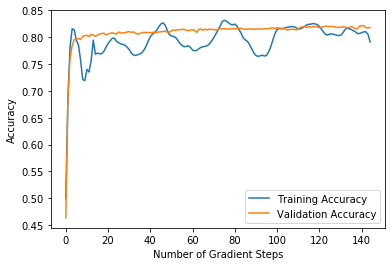

In [23]:
main(batchSize=batchSize,numEpochs=numEpochs,lr=lr,evalEvery=evalEvery)